# 国能日新光伏功率预测大赛
      通过学习一段时间内的环境数据和对应的光伏发电功率，训练模型，通过给定某时间点预测的环境数据，预测该时间点的光伏发电功率。
      
      电站1，2，3，4的装机功率的值分别为10，10，40，50。实际评分时，只考虑当天实际功率的值大于等于装机功率3%的样本，即0.3，0.3,1.2,1.5以上功率的样本。

# 数据概览
训练集数据提供了4个电场的脱敏后的环境数据和电场实际辐照度和电场发电功率。测试集数据提供了4个电场的脱敏后的环境数据，需要利用这些数据预测每个时间点的光伏发电功率。

1.实际功率中的负值是因为机组在发电不足时自身会消耗电能。

2.实发幅照度中的负值视为噪声数据。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"]=False

## 数据分布情况 

###  训练集

每个风场有66859条记录。无缺失值。

In [2]:
train1 = pd.read_csv('data/train_1.csv')
train1.时间 = pd.to_datetime(train1.时间)
train1.set_index('时间',inplace=True,drop=False) # 将时间作为index，方便查询
train1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66861 entries, 2016-04-01 00:00:00 to 2018-04-30 23:44:59.985000
Data columns (total 9 columns):
时间       66861 non-null datetime64[ns]
辐照度      66861 non-null float64
风速       66861 non-null float64
风向       66861 non-null int64
温度       66861 non-null float64
压强       66861 non-null float64
湿度       66861 non-null float64
实发辐照度    66861 non-null float64
实际功率     66861 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 5.1 MB


In [137]:
train1.sample(5)

,,时间,辐照度,风速,风向,温度,压强,湿度,实发辐照度,实际功率
时间,id,,,,,,,,,
2016-09-03 02:14:59.997,14889,2016-09-03 02:14:59.997,-1.000000,-0.564767,90,0.208081,0.030303,0.591398,0.0000,-0.004000
2016-12-14 05:14:59.995,24693,2016-12-14 05:14:59.995,-1.000000,-0.678756,92,-0.490909,0.454545,0.096774,0.0000,-0.020667
2017-02-25 18:44:59.993,30933,2017-02-25 18:44:59.993,-0.864279,0.523316,289,-0.280808,0.090909,-0.763441,45.8667,0.221667
2016-08-23 03:44:59.997,13839,2016-08-23 03:44:59.997,-1.000000,-0.689119,73,0.434343,0.090909,0.698925,0.0000,-0.027000
2016-08-26 11:44:59.997,14159,2016-08-26 11:44:59.997,0.044298,-0.782383,113,0.393939,0.454545,0.354839,575.2890,5.992670


如下表，总体看最大值都在一定范围内（怀疑数据做了最大值截取），不用做利群点的检测。

In [95]:
train1.describe()

,辐照度,风速,风向,温度,压强,湿度,实发辐照度,实际功率
count,66859.000000,66859.000000,66859.000000,66859.000000,66859.000000,66859.000000,66859.000000,66859.000000
mean,-0.586860,-0.635163,162.564591,0.004482,0.117551,-0.094385,236.338269,2.105577
std,0.549501,0.286650,95.545095,0.380649,0.281298,0.457985,342.080864,2.989082
min,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-0.020000,-0.073667
25%,-1.000000,-0.844560,91.000000,-0.309091,-0.090909,-0.462366,0.000000,-0.022000
50%,-0.958530,-0.709845,115.000000,0.014141,0.090909,-0.139785,2.844670,0.000000
75%,-0.200754,-0.502591,270.000000,0.305051,0.333333,0.268817,424.249000,4.149335
max,1.000000,1.000000,359.000000,1.000000,1.000000,1.000000,1303.110000,10.485300


Text(0.5,1,'温度')

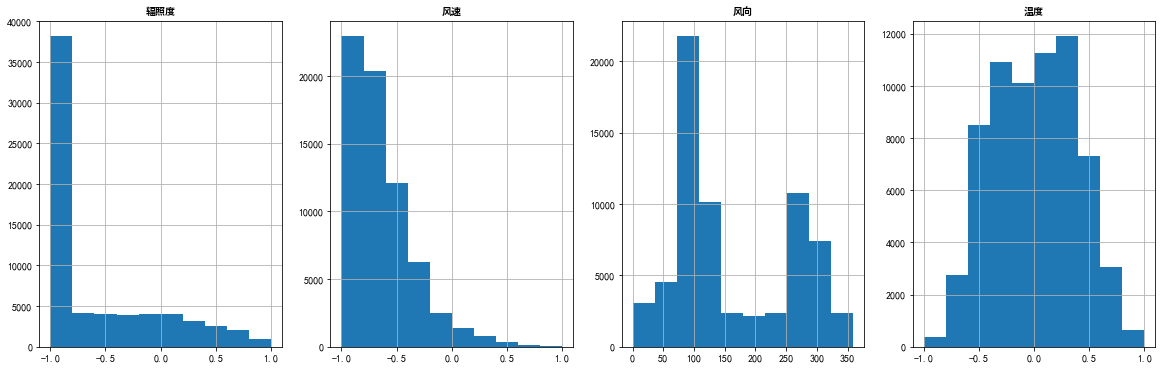

In [16]:
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc')
plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
train1['辐照度'].hist()
plt.title(u'辐照度',fontproperties=zhfont)
plt.subplot(1,4,2)
train1['风速'].hist()
plt.title(u'风速',fontproperties=zhfont)
plt.subplot(1,4,3)
train1['风向'].hist()
plt.title(u'风向',fontproperties=zhfont)
plt.subplot(1,4,4)
train1['温度'].hist()
plt.title(u'温度',fontproperties=zhfont)

Text(0.5,1,'实际功率')

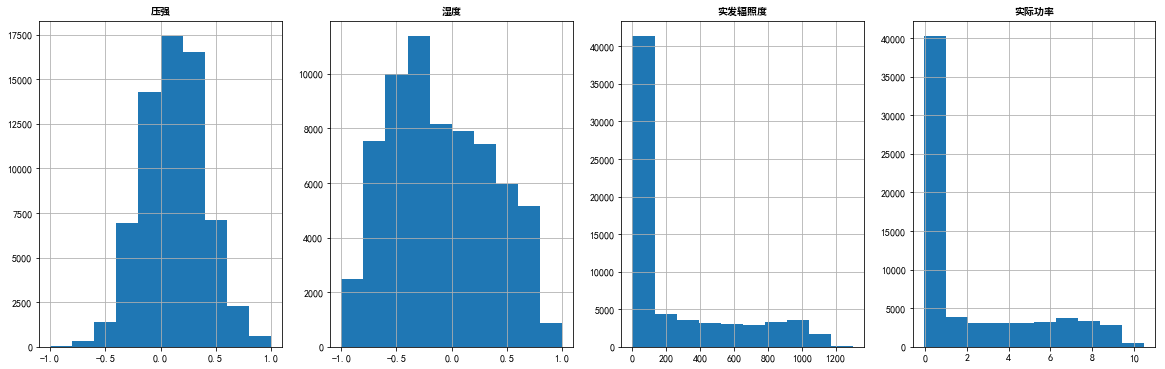

In [17]:
plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
train1['压强'].hist()
plt.title(u'压强',fontproperties=zhfont)
plt.subplot(1,4,2)
train1['湿度'].hist()
plt.title(u'湿度',fontproperties=zhfont)
plt.subplot(1,4,3)
train1['实发辐照度'].hist()
plt.title(u'实发辐照度',fontproperties=zhfont)
plt.subplot(1,4,4)
train1['实际功率'].hist()
plt.title(u'实际功率',fontproperties=zhfont)

从实际数据看，辐照度和最后的“实发辐照度”和“实际功率”分布类似。实发辐照度和实际功率的值是几乎一致的。

###  测试集合

In [6]:
test1 = pd.read_csv('data/test_1.csv')
test1.时间 = pd.to_datetime(test1.时间)
test1.set_index(['时间'],inplace=True,drop=False)
test1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11808 entries, 2018-04-30 23:59:59.985000 to 2018-08-31 23:44:59.982000
Data columns (total 8 columns):
id     11808 non-null int64
时间     11808 non-null datetime64[ns]
辐照度    11808 non-null float64
风速     11808 non-null float64
风向     11808 non-null int64
温度     11808 non-null float64
压强     11808 non-null float64
湿度     11808 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 830.2 KB


In [7]:
test1.describe()

,id,辐照度,风速,风向,温度,压强,湿度
count,11808.000000,11808.000000,11808.000000,11808.000000,11808.000000,11808.000000,11808.000000
mean,5904.500000,-0.484953,-0.562924,124.727388,0.066497,-0.074385,0.189452
std,3408.820324,0.616295,0.254866,76.842524,0.349502,0.326285,0.434701
min,1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,2952.750000,-1.000000,-0.748503,89.000000,-0.123675,-0.333333,-0.139535
50%,5904.500000,-0.819767,-0.592814,101.000000,0.074205,-0.083333,0.232558
75%,8856.250000,0.005814,-0.413174,118.000000,0.314488,0.083333,0.534884
max,11808.000000,1.000000,1.000000,359.000000,1.000000,1.000000,1.000000


## 数据相关性分析

In [167]:
train1.corr()

,辐照度,风速,风向,温度,压强,湿度,实发辐照度,实际功率
辐照度,1.000000,-0.142853,-0.025964,0.397014,-0.112976,-0.410787,0.735769,0.740987
风速,-0.142853,1.000000,0.225245,0.040933,-0.040248,-0.124255,-0.081660,-0.094576
风向,-0.025964,0.225245,1.000000,-0.338970,0.219645,-0.205834,0.004521,0.019179
温度,0.397014,0.040933,-0.338970,1.000000,-0.301537,0.136485,0.238329,0.213873
压强,-0.112976,-0.040248,0.219645,-0.301537,1.000000,0.216154,-0.094898,-0.073916
湿度,-0.410787,-0.124255,-0.205834,0.136485,0.216154,1.000000,-0.383990,-0.368342
实发辐照度,0.735769,-0.081660,0.004521,0.238329,-0.094898,-0.383990,1.000000,0.961298
实际功率,0.740987,-0.094576,0.019179,0.213873,-0.073916,-0.368342,0.961298,1.000000


依据相关系数，实发辐照度和实际功率的相关性0.96，福照度与实际功率的相关系数为0.74.

## 辐照度为-1的数据 

辐照度为-1的数量站到了总数据量的50%(达30000多条)，大多是晚上或清晨的数据。

In [85]:
train1.loc[train1['辐照度']==-1,['时间','实发辐照度','实际功率']].sort_values('实际功率',ascending=False).sample(10)

,时间,实发辐照度,实际功率
3957,2016-05-12 05:14:59.999,0.000,-0.022333
54443,2017-12-22 15:59:59.987,302.080,2.851670
28279,2017-01-29 03:14:59.994,0.000,-0.022000
36317,2017-04-24 04:44:59.992,0.000,-0.022000
30012,2017-02-16 04:29:59.994,0.000,-0.020667
3735,2016-05-09 21:44:59.999,0.000,-0.022000
58105,2018-01-29 19:29:59.987,0.000,-0.021667
47049,2017-08-14 00:59:59.990,0.000,-0.022000
53375,2017-12-11 12:59:59.988,948.978,8.690670
49731,2017-10-26 23:44:59.988,0.000,-0.018000


但也有很多其他时间的数据，约2000多条。

In [145]:
train1[(train1['辐照度']==-1) & (train1['实际功率']>1)].sample(10)

,,时间,辐照度,风速,风向,温度,压强,湿度,实发辐照度,实际功率
时间,id,,,,,,,,,
2017-12-02 09:59:59.988,52499,2017-12-02 09:59:59.988,-1.0,-0.730570,59,-0.127273,0.212121,-0.333333,548.978,5.99700
2018-01-07 15:44:59.987,55978,2018-01-07 15:44:59.987,-1.0,-0.564767,112,-0.410101,0.333333,0.505376,310.045,3.20967
2018-03-21 17:14:59.986,62992,2018-03-21 17:14:59.986,-1.0,-0.906736,27,-0.426263,-0.151515,-0.698925,398.507,3.62833
2018-03-11 15:44:59.986,62026,2018-03-11 15:44:59.986,-1.0,-0.699482,72,-0.406061,-0.454545,-0.311828,903.182,7.97567
2018-01-04 16:29:59.987,55693,2018-01-04 16:29:59.987,-1.0,-0.927461,326,-0.474747,0.212121,-0.010753,505.884,4.60733
2017-12-31 10:14:59.987,55284,2017-12-31 10:14:59.987,-1.0,-0.813472,299,-0.292929,0.272727,0.526882,541.582,5.97367
2017-12-19 10:59:59.987,54135,2017-12-19 10:59:59.987,-1.0,-0.844560,42,-0.151515,0.818182,0.462366,729.316,6.71000
2018-04-06 16:44:59.985,64526,2018-04-06 16:44:59.985,-1.0,-0.813472,49,-0.402020,0.030303,-0.698925,731.947,6.67133
2017-12-27 13:29:59.987,54913,2017-12-27 13:29:59.987,-1.0,-0.461140,251,-0.381818,0.696970,-0.075269,958.294,8.73700


下面数据可以看出，辐照度很多白天为-1的数据似乎是不对的。

In [170]:
train1['2017-12-27 12':'2017-12-27 15']

,时间,辐照度,风速,风向,温度,压强,湿度,实发辐照度,实际功率
时间,,,,,,,,,
2017-12-27 12:14:59.987,2017-12-27 12:14:59.987,-1.0,-0.388601,249,-0.369697,0.696970,-0.053763,895.858,8.52133
2017-12-27 12:29:59.987,2017-12-27 12:29:59.987,-1.0,-0.398964,249,-0.369697,0.696970,-0.075269,916.125,8.58300
2017-12-27 12:44:59.987,2017-12-27 12:44:59.987,-1.0,-0.409326,248,-0.373737,0.696970,-0.075269,944.711,8.82167
2017-12-27 12:59:59.987,2017-12-27 12:59:59.987,-1.0,-0.419689,249,-0.377778,0.696970,-0.075269,951.893,8.38267
2017-12-27 13:14:59.987,2017-12-27 13:14:59.987,-1.0,-0.440415,250,-0.377778,0.696970,-0.075269,957.511,8.06900
2017-12-27 13:29:59.987,2017-12-27 13:29:59.987,-1.0,-0.461140,251,-0.381818,0.696970,-0.075269,958.294,8.73700
2017-12-27 13:44:59.987,2017-12-27 13:44:59.987,-1.0,-0.481865,253,-0.385859,0.696970,-0.075269,954.311,8.45333
2017-12-27 13:59:59.987,2017-12-27 13:59:59.987,-1.0,-0.492228,255,-0.385859,0.696970,-0.075269,946.773,7.54867
2017-12-27 14:14:59.987,2017-12-27 14:14:59.987,-1.0,-0.523316,256,-0.389899,0.696970,-0.075269,931.769,8.35500


## 变量的时间分布情况 

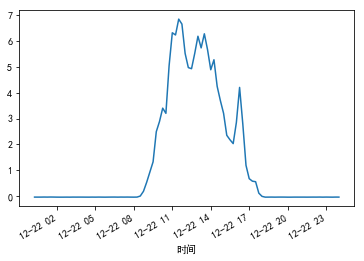

In [182]:
train1['2017-12-22 ']['实际功率'].plot()

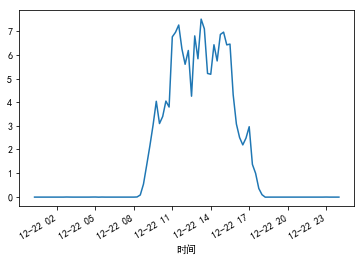

In [181]:
train1['2016-12-22']['实际功率'].plot()

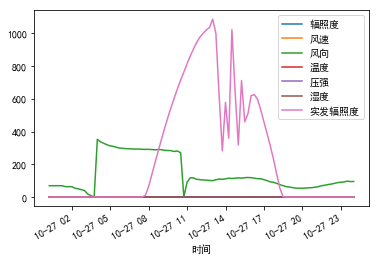

In [176]:
train1['2017-10-27 '].iloc[:,1:-1].plot()

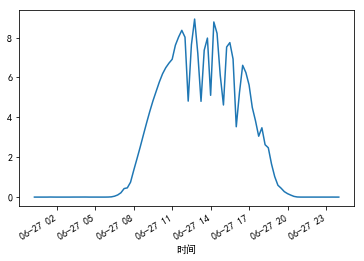

In [174]:
train1['2017-06-27 ']['实际功率'].plot()

## 数据离群点分析

In [ ]:
train1.sort_values()

#  数据预处理


## 时间处理

对时间字段进行拆分，拆分为月，日，时，分四个字段


In [3]:
train1_f = train1
train1_f['月']= train1_f['时间'].apply(lambda x:x.month)
train1_f['日']= train1_f['时间'].apply(lambda x:x.day)
train1_f['小时']= train1_f['时间'].apply(lambda x:x.hour)
train1_f['分钟']= train1_f['时间'].apply(lambda x:x.minute)

In [14]:
def get_hour(x):
    h = int(x[11:13])
    m = int(x[14:16])
    if m in [14, 29, 44]:
        m += 1
    if m == 59:
        m = 0
        h += 1
    if h == 24:
        h = 0
    return h * 60 + m

In [16]:
get_hour('2018-02-01 00:29:59.986')

30

In [19]:
train1_f['分钟'].sample(10)

时间
2018-03-02 00:30:00    30
2017-08-04 11:30:00    30
2016-11-15 03:00:00     0
2016-12-22 03:30:00    30
2017-02-13 14:30:00    30
2016-11-03 11:15:00    15
2018-03-23 11:30:00    30
2017-08-16 06:15:00    15
2016-12-07 11:30:00    30
2016-08-18 22:30:00    30
Name: 分钟, dtype: int64

# 建模

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

## 单模型验证

先去掉'时间'和''辐照度''，试一试。

In [13]:
params_xgb={
'booster':'gbtree',
'gamma':0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
'max_depth':10, # 构建树的深度，越大越容易过拟合
'lambda':2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.7, # 生成树时进行的列采样
'min_child_weight':2, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
'silent':1 ,#设置成1则没有运行信息输出，最好是设置为0.
'eta': 0.01, # 如同学习率
'seed':1000,
'nthread':-1# cpu 线程数
#'eval_metric': 'auc'
}
num_rounds = 500 # 迭代次数

params_lgb = {
    "objective": "regression",
    "metric": "mae",
    "num_leaves": 30,
    "min_child_samples": 100,
    "learning_rate": 0.03,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 666,
    "verbosity": -1
}

### 原始特征 

In [17]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(train1[[ '辐照度','风速', '风向', '温度', '压强', '湿度']],train1['实际功率'],test_size=0.3, random_state=123)
xg_model = xgb.train(params_xgb,xgb.DMatrix(xtrain1,label=ytrain1),num_rounds)
mean_absolute_error(xg_model.predict(xgb.DMatrix(xtest1)),ytest1)

1.143421271989845

In [16]:
lgb_train = lgb.Dataset(xtrain1, label=ytrain1)
lgb_eval = lgb.Dataset(xtest1, ytest1, reference=lgb_train)
gbm = lgb.train(params_lgb,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=50,
                verbose_eval=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.630387
[200]	valid_0's l1: 0.518589
[300]	valid_0's l1: 0.495109
[400]	valid_0's l1: 0.481899
[500]	valid_0's l1: 0.471886
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.471886


### 将时间拆分为月日时分特征
对特征工程后的数据进行单模型建模。

In [10]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(train1_f[['辐照度','风速', '风向', '温度', '压强', '湿度','月','日','小时','分钟']],train1['实际功率'],test_size=0.3, random_state=123)
xg_model = xgb.train(params_xgb,xgb.DMatrix(xtrain1,label=ytrain1),num_rounds)
mean_absolute_error(xg_model.predict(xgb.DMatrix(xtest1)),ytest1)

1.41141046508818

## 线性模型

In [ ]:
xgb.XGBRegressor().train()